In [ ]:
!pip install noisereduce
!pip install SpeechRecognition


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 18.3 MB/s eta 0:00:00


In [ ]:
import subprocess
import noisereduce as nr
import soundfile as sf
import speech_recognition as sr
import librosa
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
def convert_audio_to_text(audio_path):
    output_path = "converted_audio.wav"
    subprocess.call(['ffmpeg', '-i', audio_path, output_path])

    audio_data, sample_rate = sf.read(output_path)
    reduced_noise = nr.reduce_noise(y=audio_data, sr=sample_rate)
    sf.write('output_audio.wav', reduced_noise, sample_rate)

    audio_data, sample_rate = librosa.load('output_audio.wav')

    smoothed_audio = signal.medfilt(audio_data, kernel_size=9)

    sf.write('smoothed_audio.wav', smoothed_audio, sample_rate)

    r = sr.Recognizer()
    with sr.AudioFile('smoothed_audio.wav') as source:
        audio_data = r.record(source)
        audio_text = r.recognize_google(audio_data, language='te-IN')

    return audio_text

In [ ]:
def get_most_similar_question(user_input, vectorizer, question_vectors, questions):
    user_input_vector = vectorizer.transform([user_input])
    similarities = cosine_similarity(user_input_vector, question_vectors)
    most_similar_index = np.argmax(similarities)
    return questions[most_similar_index], similarities[0, most_similar_index]

In [ ]:
def generate_response(user_input, tokenizer, max_sequence_length, model):
    input_sequences = tokenizer.texts_to_sequences([user_input])
    input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
    response = model.predict(input_sequences)
    response = np.argmax(response, axis=2)
    response = tokenizer.sequences_to_texts(response)
    response = response[0].replace('<start>', '').replace('<end>', '').strip()
    return response

In [ ]:
def get_answer(user_input, vectorizer, question_vectors, questions, answers, tokenizer, max_sequence_length, model):
    similar_question, similarity_score = get_most_similar_question(user_input, vectorizer, question_vectors, questions)
    if similarity_score > 0.8:
        similar_question_index = questions.index(similar_question)
        return answers[similar_question_index]
    else:
        return generate_response(user_input, tokenizer, max_sequence_length, model)

In [ ]:
def handle_greetings(user_input):
    greetings = ['హలో', 'నమస్తే', 'సుప్రభాతం', 'శుభోదయం']
    for greeting in greetings:
        if greeting in user_input:
            return 'హలో! నేను మీకు ఎలా సహాయం చేచ్చాలనుకుంటున్నాను.'
    return None

In [ ]:
def handle_closing_greetings(user_input):
    closing_greetings = ['ధన్యవాదములు', 'శుభ రాత్రి', 'అలవాట్యాలు']
    for closing_greeting in closing_greetings:
        if closing_greeting in user_input:
            return 'మీకు సహాయం చేయండి. మీకు ఇంకా ఏమి కావాలంటే చెప్పండి.'
    return None

In [ ]:
def start_chatbot():

    data = pd.read_excel('agrobot_dataset.xlsx', sheet_name=None)
    all_data = pd.concat(data.values(), ignore_index=True)
    questions = all_data['Question'].astype(str).tolist()
    answers = all_data['Answer'].astype(str).tolist()

    vectorizer = TfidfVectorizer()
    question_vectors = vectorizer.fit_transform(questions)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(questions)
    max_sequence_length = max([len(seq.split()) for seq in questions])
    input_sequences = tokenizer.texts_to_sequences(questions)
    input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
    target_sequences = tokenizer.texts_to_sequences(answers)
    target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')

    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dense(len(tokenizer.word_index) + 1, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(input_sequences, np.expand_dims(target_sequences, -1), epochs=100)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

    print("Chatbot: హలో! మీకు ఎలా సహాయం చేచ్చాలనుకుంటున్నాను. Type 'quit' to exit.")
    while True:
        user_input = input("You: ")
        if user_input.lower() == 'quit':
            break
        if user_input.lower() == 'audio':
            audio_path = input("Please provide the path to the audio file: ")
            try:
                audio_text = convert_audio_to_text(audio_path)
                print("Chatbot (Audio):", audio_text)
                answer = get_answer(audio_text, vectorizer, question_vectors, questions, answers, tokenizer, max_sequence_length, model)
                if answer:
                    print("Chatbot:", answer)
                else:
                    response = generate_response(audio_text, tokenizer, max_sequence_length, model)
                    print("Chatbot:", response)
            except Exception as e:
                print("Error occurred while processing the audio:", str(e))
        else:
            greeting_response = handle_greetings(user_input)
            closing_greeting_response = handle_closing_greetings(user_input)
            if greeting_response:
                print("Chatbot:", greeting_response)
            elif closing_greeting_response:
                print("Chatbot:", closing_greeting_response)
            else:
                answer = get_answer(user_input, vectorizer, question_vectors, questions, answers, tokenizer, max_sequence_length, model)
                if answer:
                    print("Chatbot:", answer)
                else:
                    response = generate_response(user_input, tokenizer, max_sequence_length, model)
                    print("Chatbot:", response)

Epoch 1/100
48/48 [==============================] - 14s 246ms/step - loss: 5.8558 - accuracy: 0.2395
Epoch 2/100
48/48 [==============================] - 13s 260ms/step - loss: 5.1674 - accuracy: 0.2461
Epoch 3/100
48/48 [==============================] - 11s 232ms/step - loss: 5.0404 - accuracy: 0.2624
Epoch 4/100
48/48 [==============================] - 6s 125ms/step - loss: 4.9077 - accuracy: 0.2815
Epoch 5/100
48/48 [==============================] - 7s 148ms/step - loss: 4.8200 - accuracy: 0.2899
Epoch 6/100
48/48 [==============================] - 6s 125ms/step - loss: 4.7387 - accuracy: 0.2946
Epoch 7/100
48/48 [==============================] - 7s 150ms/step - loss: 4.6815 - accuracy: 0.2971
Epoch 8/100
48/48 [==============================] - 6s 126ms/step - loss: 4.6279 - accuracy: 0.3010
Epoch 9/100
48/48 [==============================] - 7s 149ms/step - loss: 4.5913 - accuracy: 0.3023
Epoch 10/100
48/48 [==============================] - 6s 125ms/step - loss: 4.5597 - acc

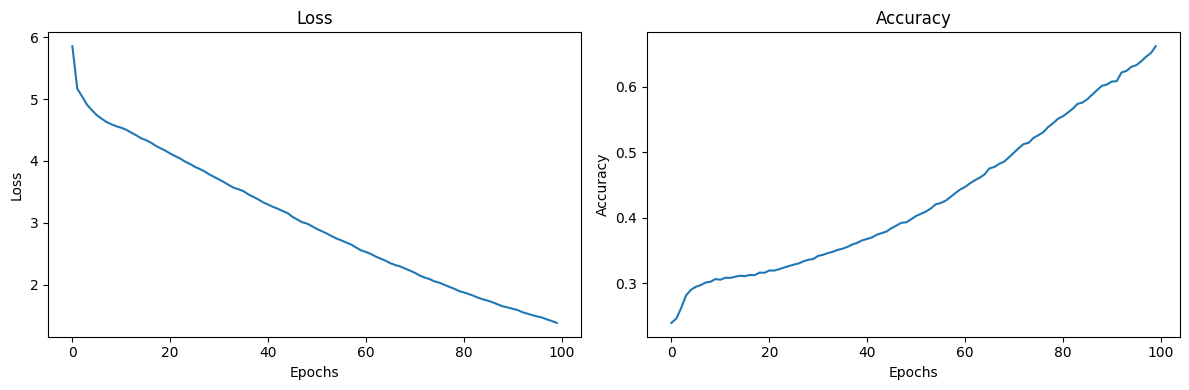

Chatbot: హలో! మీకు ఎలా సహాయం చేచ్చాలనుకుంటున్నాను. Type 'quit' to exit.
Chatbot: నీటిపారుదల యొక్క స్ప్రింక్లర్ పద్ధతి తేలికపాటి నేల మరియు నీటి కొరత ఉన్న ప్రాంతాలకు అనుకూలంగా ఉంటుంది. 30% నీటిని ఆదా చేయడానికి బెడ్ ప్లాంటింగ్ పద్ధతులను కూడా అటువంటి ప్రాంతాలలో అవలంబించవచ్చు


In [ ]:
start_chatbot()

Gui using gradio:

In [1]:
import os
import pandas as pd
import time
import speech_recognition as sr
import openai
import gradio as gr
openai.api_key = 'Provide your API Key'

def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0
    )
    return response.choices[0].message["content"]


def voiceinput():
    r = sr.Recognizer()
    with sr.Microphone() as source:
        print("Speak Anything:")
        audio = r.listen(source, timeout=5, phrase_time_limit=10)
        try:
            text = r.recognize_google(audio,language='te-IN')
            print("You said: {}".format(text))
            return text
        except sr.UnknownValueError:
            print("Sorry, we could not recognize what you said. You can try again.")
        except sr.RequestError as e:
            print("Speech recognition request error: {}".format(e))
        return "Sorry, we could not recognize what you said. You can try again."






with gr.Blocks() as demo:
    gr.Markdown("#  --------------------------------------------------------------------------AGROBOT TELUGU--------------------------------------------------------------------------------")
    with gr.Row():
        with gr.Column(scale=1, min_width=600):
          chatbot =gr.Chatbot([], elem_id="chatbot").style(height=400)
    with gr.Row():
            msg = gr.Textbox(
                show_label=False,
                placeholder="Enter query and press enter, or upload an Audio file",
            ).style(container=False)
            voice = gr.Button("Click to record").style(full_width=False)
    clear = gr.Button("Clear")
    def textinput(input, history=[]):
        output = get_completion(input)
        history.append((input, output))
        # time.sleep(2)
        return "", history
    msg.submit( textinput, [msg, chatbot], [msg, chatbot])
    clear.click(lambda: None, None, chatbot, queue=False)


   
    def voice_option():
        input_text = voiceinput()
        if input_text:
            history, output = textinput(input_text)
            print("speak now :")
            return output
        else:
            return "Sorry, we could not recognize what you said. You can try again."
    voice.click(voice_option, inputs=None, outputs=chatbot)
    clear.click(lambda: None, None, chatbot, queue=False)
                
demo.launch()



s:\softwares\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
